In [1]:
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM, Dense, Flatten, BatchNormalization, Dropout, GRU
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import module
import gc
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
countriesOfInterest = {"HK", "JP", 'ZA', 'TN', 'TR', 'GB', 'MX', 'US', 'CO', 'EC', 'AU', 'NZ'}
countriesOfInterest = ["ZA", "EG", "TW", "JP", "DK", "FI", "US", "CA", "AU", "NZ", "BR", "CO"]

enc = OneHotEncoder()
enc.fit(np.array(countriesOfInterest).reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

### Test Sampling

(12, 30, 25)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 30, 25)            100       
_________________________________________________________________
lstm (LSTM)                  (None, 30, 16)            2688      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 16)            64        
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)    

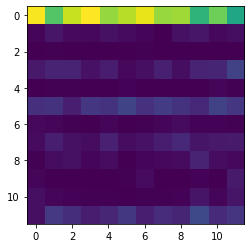

24000/24000 [==============================] - 1s 27us/sample


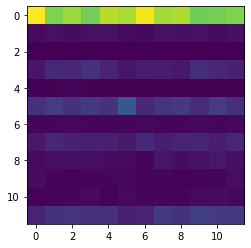

3_seconds_10_samples iteration 10
4800/4800 [==============================] - 1s 116us/sample


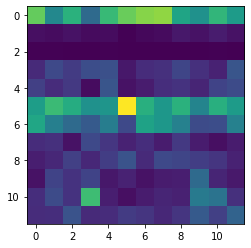

24000/24000 [==============================] - 1s 27us/sample


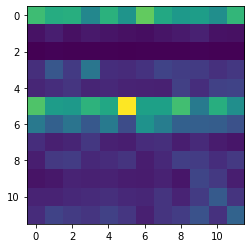

3_seconds_10_samples iteration 15
4800/4800 [==============================] - 1s 117us/sample


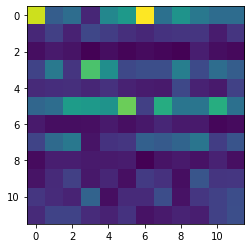

24000/24000 [==============================] - 1s 30us/sample


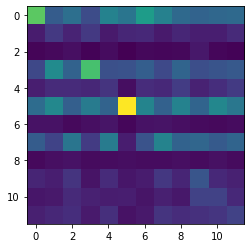

In [ ]:
train_n = 100
sample_n = train_n * 20
val_n  = int(train_n/5)
valsample_n = val_n * 20
for seconds in [3, 5, 10]:
    for samplerate in [10, 100]:
        train_x, train_labels, val_x, val_labels, class_weights = module.getSamples(1, 1, 1, 1, 
                                                                                    seconds, 
                                                                                    samplerate, 
                                                                                    countriesOfInterest, 
                                                                                    enc, 
                                                                                    verbose = 0)
        print(train_x.shape)
        model = keras.Sequential()
        model.add(BatchNormalization(input_shape=(train_x.shape[1], train_x.shape[2])))

        model.add(LSTM(16, 
                       input_shape=(train_x.shape[1], train_x.shape[2]), 
                       return_sequences = True
                      ))
        model.add(BatchNormalization())
        model.add(LSTM(32, 
                       return_sequences = False,
                       go_backwards = True
                      ))
        model.add(BatchNormalization())
        model.add(Dense(16, activation= "relu"))
        model.add(BatchNormalization())
        model.add(Dense(len(enc.categories_[0]), activation= "softmax"))
        adam = keras.optimizers.Adam(lr=0.001, amsgrad = True)
        model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
        del train_x, train_labels, val_x, val_labels, class_weights
        gc.collect()
        print(model.summary())
        desc = str(seconds) + "_seconds_" + str(samplerate) + "_samples"
        log_dir = os.path.join(
            "logs",
            "Quality",
            desc
        )
        model_dir = os.path.join(
            "pickle",
            desc
        )


        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        epochs = 2
        iterations = 50
        learn_rate = 0.001
        batch_size = 4096
        model = module.train(iterations, learn_rate, train_n, sample_n, val_n, valsample_n, seconds, samplerate,
                        countriesOfInterest, enc, epochs, tensorboard_callback, model_dir,
                        model, batch_size)
        del model, model_dir, log_dir, desc, adam
        gc.collect()